## Working file : agent_plans_with_ASV

In [169]:
# coding: utf-8
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from matplotlib import dates as mdates
#from matrix import Matrix
import math 
import os
import plotly.express as px 
from pylab import savefig
from lxml import etree
import utm
import geopy
from matplotlib.pyplot import hist
import geopandas as gpd
import cbsodata
import folium
from folium import plugins
from folium.plugins import HeatMap
import plotly.graph_objects as go


#import geoplot
#import geoplot.crs as gcrs

In [261]:
os.getcwd()

'/Users/xinyun/Documents/Stage4A'

## Functions allows to browse the file and create a dataframe 

In [290]:
# function takes file path as input
# returns a dataframe contains all demand in ascending order of departure time and all listes of origin and 
# destination coordinates
def build_all_demand_df(dir):
    # find xml file name
    fname = dir
    # read xml file
    tree = etree.parse(fname)
    root = tree.getroot()  
    # Initialization 
    demand, id_nb, O_x, O_y, D_x, D_y, dep_time, mobility_service = ([] for i in range(8))

    # Iterate through the root node to get the child node 
    for user in tree.xpath("/population/person") :
        ID = user.get('id')
        plan = user.xpath('plan')
        a = plan[0].xpath("activity")   # [0] is necessary 
        leg = plan[0].xpath("leg")
        x1 = []
        y1 = []
        x2 = []
        y2 = []
        time = []
        service = []
        for b in a :      # Iterate through activity in plan
            x1.append(b.get("x"))
            y1.append(b.get('y'))
            x2.append(b.get("x"))
            y2.append(b.get('y'))
        for c in leg :   # Iterate through leg in plan
            if c.get('mode') == 'car':   # travel mode = car 
                service.append('PersonalVehicle')
            else:
                service.append(c.get('mode'))  # get other travel modes
            time.append(c.get('dep_time')) # append departure time

        x1.pop()
        y1.pop()
        x2.pop(0)
        y2.pop(0)
        id_ = [ID]*len(x1)
        id_nb+=id_ # id
        O_x+=x1   # x-coordinate of the origin
        O_y+=y1   # x-coordinate of the destination
        D_x+=x2   # y-coordinate of the origin
        D_y+=y2   # y-coordinate of the destination
        dep_time+=time  # departure time
        mobility_service+=service  # mobility service
    # Create a list of combinasion of 4 columns
    demand = list(zip(id_nb,dep_time,O_x,O_y,D_x,D_y,mobility_service))   
    #Create dataframe from listes
    demandDf = pd.DataFrame(demand, columns = ['ID', 'DEPARTURE', 'O_x', 'O_y', 'D_x', 'D_y', 'SERVICE'])
    # Concatenate and rename coordinates columns  
    demandDf['ORIGIN'] = demandDf.apply(lambda x : '%s %s' % (x['O_x'], x['O_y']), axis=1)
    demandDf['DESTINATION'] = demandDf.apply(lambda x : '%s %s' % (x['D_x'], x['D_y']), axis=1)
    # Delet the four origins coordinates columns
    demandDf = demandDf.drop(labels=['O_x', 'O_y', 'D_x', 'D_y'], axis=1)
    #Mobility = demandDf['SERVICE'].tolist()
    #indices = [i for i, x in enumerate(Mobility) if x == 'PersonalVehicle']
    #demandDf = demandDf.loc[indices]
    demandDf = demandDf[['ID', 'DEPARTURE', 'ORIGIN', 'DESTINATION', 'SERVICE']]
     # switch to incremental order by dep_time
    demandDf = demandDf.sort_values(by = 'DEPARTURE') 
    demandDf = demandDf.reset_index(drop=True)
    return demandDf, O_x, O_y, D_x, D_y

In [291]:
# function takes file path as input
# returns a dataframe contains only car users in ascending order of departure time
def build_car_users_only_df(dir):
    allUserDf, O_x, O_y, D_x, D_y  = build_all_demand_df(dir)
    mobility = allUserDf['SERVICE'].tolist()
    indices = [i for i, x in enumerate(mobility) if x == 'PersonalVehicle']
    df = allUserDf.loc[indices]
    df = df.reset_index(drop=True)
    return df

## Dataframe of all users in ascending order of departure time

In [292]:
dir = 'data/agent_plans_with_SAV.xml' # path of file
allUserDf, O_x, O_y, D_x, D_y = build_all_demand_df(dir) 
allUserDf

,ID,DEPARTURE,ORIGIN,DESTINATION,SERVICE
0,1092778,02:25:28,630209.2183736941 5802560.252655378,628139.6507828436 5805236.524603739,taxi
1,2047996,02:34:47,706691.7915121207 5710429.208945983,629439.1110360922 5801802.608622144,pt
2,844163,02:38:18,645624.9258951969 5844635.201187612,645612.8354277287 5844389.713957095,bike
3,1055879,02:38:34,625213.2565636548 5801283.454577501,625010.44236077 5802946.676243623,walk
4,998725,02:39:31,638423.1537658195 5814097.23923733,651710.2043398552 5840611.335265805,bike
...,...,...,...,...,...
601857,941384,24:29:46,610323.4448327582 5804523.463456508,610139.8036228275 5804479.445455948,bike
601858,1074915,24:29:51,628716.9511927095 5801493.025342571,628945.7914998502 5801978.873328291,bike
601859,1038204,24:29:58,685267.4815879678 5790409.823144514,627012.8028807903 5803367.105509135,pt
601860,1127071,24:49:54,627439.3502445676 5800106.909626863,627428.2057525564 5796576.659790612,bike


## Dataframes for car users only, in ascending order of departure time

In [258]:
dir = 'data/agent_plans_with_SAV.xml' # path of file
personalVehicleDf = build_car_users_only_df(dir) 
personalVehicleDf   # P.S : I used only car users for the simulation 

,ID,DEPARTURE,ORIGIN,DESTINATION,SERVICE
0,910210,02:52:39,612379.0489281532 5816350.89446665,611691.4419278009 5816954.11609318,PersonalVehicle
1,999663,02:55:23,630538.3627080203 5810738.8288230095,737546.9351569484 5901883.143939297,PersonalVehicle
2,1114579,02:58:52,678560.9934943746 5757110.199189669,678560.9934943746 5757110.199189669,PersonalVehicle
3,1063629,03:09:10,627971.7123910612 5804577.181003605,627971.7123910612 5804577.181003605,PersonalVehicle
4,1128767,03:10:27,624865.4875424504 5793371.364701685,624885.2201303691 5794167.11471286,PersonalVehicle
...,...,...,...,...,...
157548,392613,24:28:27,649516.4371622159 5805808.736768906,649450.364888446 5805823.603616291,PersonalVehicle
157549,1042032,24:28:39,622573.6391230685 5816408.36995231,626527.3551048918 5804835.89886126,PersonalVehicle
157550,1107580,24:28:58,627455.5557569496 5803382.911728106,632463.8733670102 5803246.066693705,PersonalVehicle
157551,904619,24:29:05,618188.6065932165 5774328.079332883,628031.6209464825 5829533.568219972,PersonalVehicle


## Generate a test csv for a time period given

In [251]:
# function takes a tart time and a end time as input
# returns a dataframe of demand during this time period : [start_time ,end_time[ 
def test_df(start_time, end_time, demand_df):
    departure = demand_df["DEPARTURE"].tolist()
    id = demand_df["ID"].tolist()
    o = demand_df["ORIGIN"].tolist()
    d = demand_df["DESTINATION"].tolist()
    s = demand_df["SERVICE"].tolist()

    
    for i in range(len(departure)-1) :
        down = departure[i]
        up = departure[i+1]
        if ((int(down[:2]) == start_time-1) & (int(up[:2]) == start_time)) :
            a = i + 1
        elif ((int(down[:2]) == end_time - 1) & (int(up[:2]) == end_time)) :

            b = i + 1
    departure = departure[a:b]
    id = id[a:b]
    o = o[a:b]
    d = d[a:b]
    s = s[a:b]
    
    demand = list(zip(id,departure,o,d,s))
    testDf = pd.DataFrame(demand, columns = ['ID', 'DEPARTURE', 'ORIGIN', 'DESTINATION', 'SERVICE'])
    return testDf

In [255]:
# example of demand between 7h and 9h
testDf = test_df(7, 9, personalVehicleDf)
testDf

,ID,DEPARTURE,ORIGIN,DESTINATION,SERVICE
0,1111241,07:00:00,634035.7291712608 5798370.933920433,633013.7429947932 5797843.393080657,PersonalVehicle
1,1168071,07:00:00,646689.5975135324 5796305.536300822,625022.1658398311 5803258.391749226,PersonalVehicle
2,1163767,07:00:01,647946.4852670499 5793206.220630613,650698.8689544763 5804828.471933132,PersonalVehicle
3,1040303,07:00:02,626592.2832221197 5802782.201807101,627119.3937449739 5802857.838660972,PersonalVehicle
4,1135295,07:00:03,626373.3503814898 5795318.412810527,649225.0246550543 5787834.954252227,PersonalVehicle
...,...,...,...,...,...
18989,669847,08:59:59,671144.401814134 5756828.440589001,687346.7403420567 5742119.76719328,PersonalVehicle
18990,1084683,08:59:59,627694.0701901402 5801284.886931946,627651.4043159435 5801055.3357389495,PersonalVehicle
18991,1065005,08:59:59,627736.8477670127 5797076.775593162,627736.8477670127 5797076.775593162,PersonalVehicle
18992,382377,08:59:59,669269.0467706273 5816633.331821069,667309.4649672995 5819659.861915671,PersonalVehicle


In [262]:
# turn test dataframe to a csv file 
testDf.to_csv('demand/test_7h_9h.csv', sep = ';', index = False)

## Occurrence of nb of trips  (for all demand)

In [269]:
# function takes dataframe of demand as input
# plot and save occurrence of nb of trips 
def plot_nb_of_trips_per_user(dataframe):
    # Create a dataframe with ID and number of trips of each user
    nbTrips = dataframe.groupby(by = 'ID').size().reset_index(name='NB_OF_TRIPS')
    # occurrence of number of trips
    occ = nbTrips.groupby(by = 'NB_OF_TRIPS').size().reset_index(name='OCCURRENCE')  
    plt.figure(figsize=(10, 8))
    plt.plot(occ.NB_OF_TRIPS, occ.OCCURRENCE, color='darkgreen',alpha = 0.7, linestyle='dashed', linewidth = 2, marker='o',
    markerfacecolor='orange', markersize=8)
    plt.title('Occurrence of number of trips', fontsize=20)
    plt.xlabel('Number of trips', fontsize=18)
    plt.ylabel('Occurrence', fontsize=18)
    plt.savefig('demand/figure/occurrence.pdf')
    plt.show()

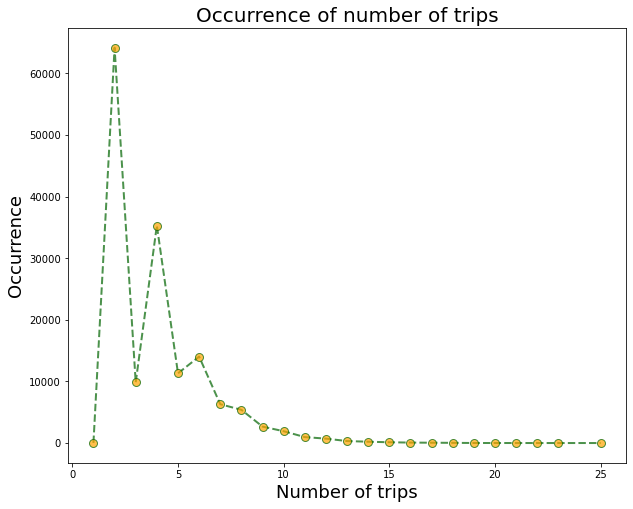

In [268]:
# number of trips per user
plot_nb_of_trips_per_user(allUserDf)

### Calculate mean, max and min of trips

In [270]:
# Calculate mean, max and min of trips
nbTrips = allUserDf.groupby(by = 'ID').size().reset_index(name='NB_OF_TRIPS')
mean = nbTrips.NB_OF_TRIPS.mean()
maximum = nbTrips.NB_OF_TRIPS.max()
mini  = nbTrips.NB_OF_TRIPS.min()
print('La moyenne de nombre de trajet par usager est :',mean,'\n', 'Le maximum nombre de trajet fait par les usagers est :', maximum,'\n','Le minimum nombre de trajet fait par les usagers est :', mini)

La moyenne de nombre de trajet par usager est : 3.9209506250855055 
 Le maximum nombre de trajet fait par les usagers est : 25 
 Le minimum nombre de trajet fait par les usagers est : 1


## Number of user per hour

In [277]:
def plot_nb_of_user_per_hour(dataframe):
    time = dataframe.DEPARTURE.values.tolist()
    # Convert departure time to hour 
    for i in range(len(time)) :
        time[i] = float(time[i][0:2]) + float(time[i][3:5]) / 60
    plt.figure(figsize=(10,8))
    plt.hist(time,range = (0,24), bins = 20, color = 'blue',alpha = 0.5,edgecolor='orange')
    plt.xlabel('Hour', fontsize=18)
    plt.ylabel('Number of user', fontsize=18)
    plt.title('Number of user per hour', fontsize=20)
    plt.savefig('demand/figure/nb_user_per_hour.pdf')
    plt.show()

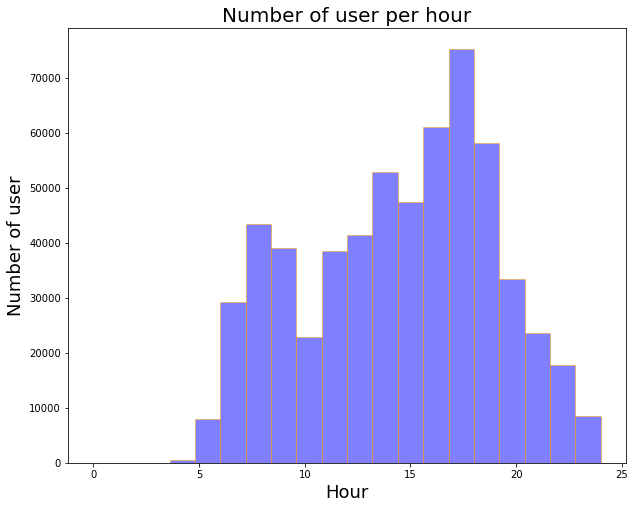

In [278]:
# number of user per hour for all demand
plot_nb_of_user_per_hour(allUserDf)

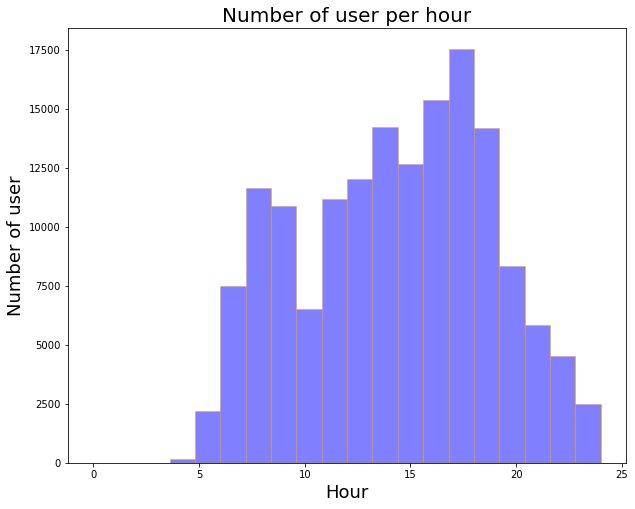

In [274]:
# number of user per hour for only car users
plot_nb_of_user_per_hour(personalVehicleDf)

## Percentage of worker and no-worker

In [275]:
# function takes as input the path of xml file
# plot and save figures of percentage 
def plot_percentage_work_or_not(dir):
    fname = dir
    # read xml file
    tree = etree.parse(fname)
    root = tree.getroot()  
    person = 0
    noworker = 0
    worker = 0
    for user in tree.xpath("/population/person") :
        person+=1
        attributes = user.xpath('attributes')
        # get users' status
        status = attributes[0][2].text
        if status == 'NoWorker' :   
            noworker+=1
        elif status == 'Worker' :
            worker+=1
    perc_noworker = round((noworker / person) * 100)
    perc_worker = round((worker / person) * 100)
    status = ['Worker', 'Noworker']
    data = [worker, noworker]
    explode = (0,0.1)
    # Creating plot
    fig1, ax1 = plt.subplots(figsize =(10, 7))
    ax1.pie(data, explode=explode, labels=status, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.legend(status, title ="status", loc ="center right")
    ax1.set_title("Percentage of worker and no-worker")
    plt.savefig('demand/figure/Percentage_status.pdf')
    # show plot
    plt.show()

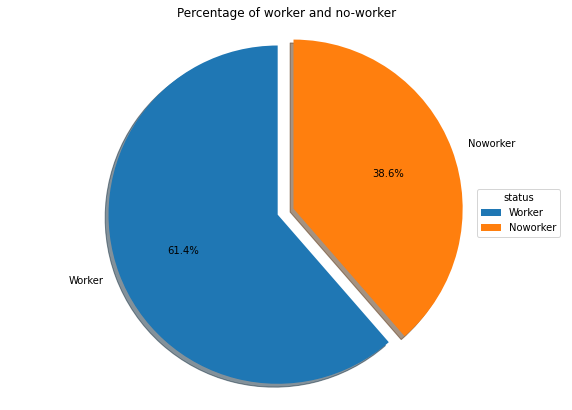

In [276]:
dir = 'data/agent_plans_with_SAV.xml'
plot_percentage_work_or_not('data/agent_plans_with_SAV.xml')

## Occurrence of number for trips for workers

In [285]:
# function takes as input path of xml file
# plot and save occurrence of nb of trips for workers
def plot_nb_of_trips_workers(dir) :
    fname = dir
    # read xml file
    tree = etree.parse(fname)
    root = tree.getroot()  
    
    worker, id_nb, O_x, O_y, D_x, D_y, dep_time, mobility_service = ([] for i in range(8))
    # Iterate through the root node to get the child node 
    for user in tree.xpath("/population/person") :
        attributes = user.xpath('attributes')
        status = attributes[0][2].text
        if status == 'Worker' :
            ID = user.get('id')
            plan = user.xpath('plan')
            a = plan[0].xpath("activity")   # [0] is necessary 
            leg = plan[0].xpath("leg")
            x1 = []
            y1 = []
            x2 = []
            y2 = []
            time = []
            service = []
            for b in a :      # Iterate through activity in plan
                x1.append(b.get("x"))
                y1.append(b.get('y'))
                x2.append(b.get("x"))
                y2.append(b.get('y'))
            for c in leg :   # Iterate through leg in plan
                if c.get('mode') == 'car':
                    service.append('PersonalVehicle')
                else:
                    service.append('Other')
                    time.append(c.get('dep_time'))

            x1.pop()
            y1.pop()
            x2.pop(0)
            y2.pop(0)
            id_ = [ID]*len(x1)
            id_nb+=id_
            O_x+=x1
            O_y+=y1
            D_x+=x2
            D_y+=y2
            dep_time+=time
            mobility_service+=service

    worker = list(zip(id_nb,dep_time,O_x,O_y,D_x,D_y,mobility_service))    # Create a list of combinasion of 4 columns
    # Create dataframe from listes
    workerDf = pd.DataFrame(worker, columns = ['ID', 'DEPARTURE', 'O_x', 'O_y', 'D_x', 'D_y', 'SERVICE']) 
    workerDf['ORIGIN'] = workerDf.apply(lambda x : '%s %s' % (x['O_x'], x['O_y']), axis=1)
    workerDf['DESTINATION'] = workerDf.apply(lambda x : '%s %s' % (x['D_x'], x['D_y']), axis=1)
    # Delet the four origins coordinates columns
    workerDf = workerDf.drop(labels=['O_x', 'O_y', 'D_x', 'D_y'], axis=1)
    
    # commented part for car users only
    """
    Mobility = workerDf['SERVICE'].tolist()
    indices = [i for i, x in enumerate(Mobility) if x == 'PersonalVehicle']
    workerDf = workerDf.loc[indices]
    """
    workerDf = workerDf[['ID', 'DEPARTURE', 'ORIGIN', 'DESTINATION', 'SERVICE']]
    workerDf = workerDf.reset_index(drop=True)
    nbTrips_worker = workerDf.groupby(by = 'ID').size().reset_index(name='NB_OF_TRIPS')  
    occ_worker = nbTrips_worker.groupby(by = 'NB_OF_TRIPS').size().reset_index(name='OCCURRENCE') 
    plt.figure(figsize=(10, 8))
    plt.plot(occ_worker.NB_OF_TRIPS, occ_worker.OCCURRENCE, color='blue',alpha = 0.7, linestyle='dashed', linewidth = 2, marker='o',
         markerfacecolor='orange', markersize=8)
    plt.title('Occurrence of number of trips for workers', fontsize=20)
    plt.xlabel('Number of trips', fontsize=18)
    plt.ylabel('Occurrence', fontsize=18)
    plt.savefig('demand/figure/occurrence_worker.pdf')
    plt.show()

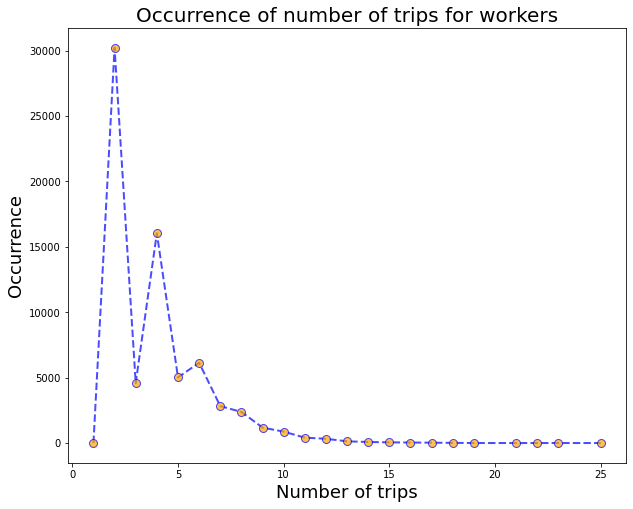

In [284]:
plot_nb_of_trips_workers(dir)

## Occurrence of number of trips for no-workers

In [294]:
def plot_nb_of_trips_no_workers(dir):
    fname = dir
    # read xml file
    tree = etree.parse(fname)
    root = tree.getroot()  
    
    noworker, id_nb, O_x, O_y, D_x, D_y, dep_time, mobility_service  = ([] for i in range(8))

    # Iterate through the root node to get the child node 
    for user in tree.xpath("/population/person") :
        attributes = user.xpath('attributes')
        status = attributes[0][2].text
        if status == 'NoWorker' :
            ID = user.get('id')
            plan = user.xpath('plan')
            a = plan[0].xpath("activity")   # [0] is necessary 
            leg = plan[0].xpath("leg")
            x1 = []
            y1 = []
            x2 = []
            y2 = []
            time = []
            service = []
            for b in a :      # Iterate through activity in plan
                x1.append(b.get("x"))
                y1.append(b.get('y'))
                x2.append(b.get("x"))
                y2.append(b.get('y'))
            for c in leg :   # Iterate through leg in plan
                if c.get('mode') == 'car':
                    service.append('PersonalVehicle')
                else:
                    service.append('Other')
                    time.append(c.get('dep_time'))

            x1.pop()
            y1.pop()
            x2.pop(0)
            y2.pop(0)
            id_ = [ID]*len(x1)
            id_nb+=id_
            O_x+=x1
            O_y+=y1
            D_x+=x2
            D_y+=y2
            dep_time+=time
            mobility_service+=service

    noworker = list(zip(id_nb,dep_time,O_x,O_y,D_x,D_y,mobility_service))    # Create a list of combinasion of 4 columns
    # Create dataframe from listes
    noworkerDf = pd.DataFrame(noworker, columns = ['ID', 'DEPARTURE', 'O_x', 'O_y', 'D_x', 'D_y', 'SERVICE']) 
    noworkerDf['ORIGIN'] = noworkerDf.apply(lambda x : '%s %s' % (x['O_x'], x['O_y']), axis=1)
    noworkerDf['DESTINATION'] = noworkerDf.apply(lambda x : '%s %s' % (x['D_x'], x['D_y']), axis=1)
    # Delet the four origins coordinates columns
    noworkerDf = noworkerDf.drop(labels=['O_x', 'O_y', 'D_x', 'D_y'], axis=1)
    # commented part for car users only
    """
    Mobility = noworkerDf['SERVICE'].tolist()
    indices = [i for i, x in enumerate(Mobility) if x == 'PersonalVehicle']
    noworkerDf = noworkerDf.loc[indices]
    """
    noworkerDf = noworkerDf[['ID', 'DEPARTURE', 'ORIGIN', 'DESTINATION', 'SERVICE']]

    nbTrips_noworker = noworkerDf.groupby(by = 'ID').size().reset_index(name='NB_OF_TRIPS')  
    occ_noworker = nbTrips_noworker.groupby(by = 'NB_OF_TRIPS').size().reset_index(name='OCCURRENCE') 
    plt.figure(figsize=(10, 8))
    plt.plot(occ_noworker.NB_OF_TRIPS, occ_noworker.OCCURRENCE, color='purple',alpha = 0.7, linestyle='dashed', linewidth = 2, marker='o',
         markerfacecolor='orange', markersize=8)
    plt.title('Occurrence of number of trips for no-workers', fontsize=20)
    plt.xlabel('Number of trips', fontsize=18)
    plt.ylabel('Occurrence', fontsize=18)
    plt.savefig('demand/figure/occurrence_noworker.pdf')
    plt.show()


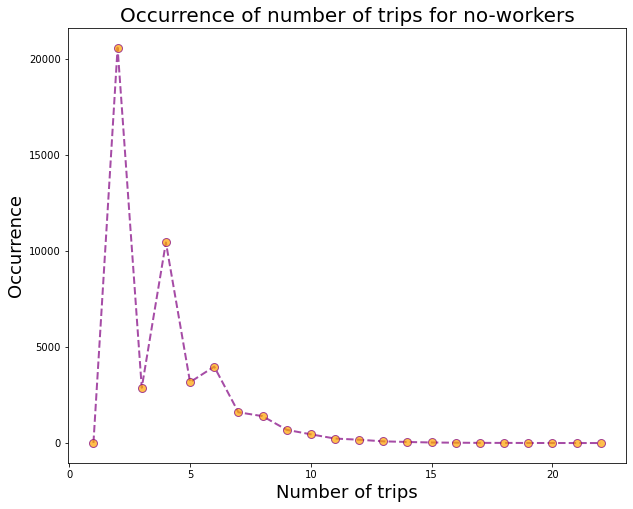

In [298]:
plot_nb_of_trips_no_workers(dir)

## Turn string lists of origin and destination coordinates to float lists

In [296]:
# function build_all_demand_dir(dir) returns all listes of coordinates
# allUserDf, O_x, O_y, D_x, D_y = build_all_demand_df(dir) 
O_x = [eval(i) for i in O_x]  # x-coordinates of origin 
O_y = [eval(i) for i in O_y]  # y-coordinates of origin 
D_x = [eval(i) for i in D_x]  # x-coordinates of destination 
D_y = [eval(i) for i in D_y]  # y-coordinates of destination

In [299]:
distance = []
for i in range(len(O_x)) :
    d = math.sqrt((O_x[i] - D_x[i])**2 + (O_y[i] - D_y[i])**2)
    distance.append(d)

In [301]:
average = sum(distance) / len(distance)
print('average distance traveled by uers is : ',average, 'm')

average distance traveled by uers is :  10510.574930298075 m


## Preparations for heatmap matrix 

### Function that takes as input x,y of the area, returns the GPS coordinates of the center of the area

In [152]:
# Function takes as input x,y of the area, returns the GPS coordinates of the center of the area
def zoneCenter(x, y, pasX, pasY) :
    x1 = O_Xmin + pasX * x
    y1 = O_Ymin + pasY * y
    x2 = x1 + pasX
    y2 = y1 + pasY
    X = (x1 + x2) / 2
    Y = (y1 + y2) / 2
    (X,Y) = utm.to_latlon(X,Y,31,'U')
    return (X,Y)

### Function that converts GPS coordinates to postalcode in Amsterdam

In [153]:
# Fonction qui convertit GPS code postale
geo_locator = geopy.Nominatim(user_agent='1234')
# Latitude, Longitude
def geoLocator(lat,long) :
    r = geo_locator.reverse((lat, long))
    return (r.raw['address']['postcode'])

### New landmark with (0,0) = (52.295259699552446, 4.78129333009194)

In [154]:
(x,y) = zoneCenter(165,538, 500, 500)
print('coordonnée GPS du centre de la zone ',(165,538), 'est :', (x,y))

coordonnée GPS du centre de la zone  (165, 538) est : (52.43454327241714, 4.786905720997837)


In [155]:
(x,y) = zoneCenter(193,538, 500, 500)
print('coordonnée GPS du centre de la zone ',(193,538), 'est :', (x,y))

coordonnée GPS du centre de la zone  (193, 538) est : (52.43125327632093, 4.9927172651752105)


In [156]:
(x,y) = zoneCenter(193,507, 500, 500)
print('coordonnée GPS du centre de la zone ',(193,507), 'est :', (x,y))

coordonnée GPS du centre de la zone  (193, 507) est : (52.29198609648396, 4.986459436727295)


### Get min of x,y-coordinates for both origin and destination

In [302]:
Xmin = min(O_x + D_x)
Ymin = min(O_y + D_y)

In [304]:
# calculate the 4 endpoints of the Amsterdam center
# x0, y0 : min, x1, y1 : max
x0 = 165 * 500 + Xmin  # each square in matrix is 500m x 500m
x1 = 193 * 500 + Xmin
y0 = 507 * 500 + Ymin
y1 = 538 * 500 + Ymin

## Loop which creat lists of origin and destination coordinates  according to each time period

In [315]:
# morning (5h - 11h)
# afternoon (16h - 20h)
# creat lists of coordinates during each time period (1 hour)
O_xm, O_ym, O_xs, O_ys, D_xm, D_ym, D_xs, D_ys = ([] for i in range(8))
O_xm_5, O_ym_5,O_xm_6, O_ym_6,O_xm_7, O_ym_7, O_xm_8, O_ym_8, O_xm_9, O_ym_9, O_xm_10, O_ym_10 = ([] for i in range(12))
D_xm_5, D_ym_5,D_xm_6, D_ym_6,D_xm_7, D_ym_7, D_xm_8, D_ym_8, D_xm_9, D_ym_9, D_xm_10, D_ym_10 = ([] for i in range(12))
O_xs_16, O_ys_16, O_xs_17, O_ys_17, O_xs_18, O_ys_18, O_xs_19, O_ys_19 = ([] for i in range(8))
D_xs_16, D_ys_16, D_xs_17, D_ys_17, D_xs_18, D_ys_18, D_xs_19, D_ys_19 = ([] for i in range(8))
for i in (range(len(dep_time))) :
    time = int(dep_time[i][:2])
    if (time <= 11) & (time >= 5) :  # Origin/Destination in the morning
        O_xm.append(O_x[i])
        O_ym.append(O_y[i])
        D_xm.append(D_x[i])
        D_ym.append(D_y[i])
        if (time < 6) & (time >= 5) :  # Between 5h - 6h
            O_xm_5.append(O_x[i])
            O_ym_5.append(O_y[i])
            D_xm_5.append(D_x[i])
            D_ym_5.append(D_y[i])
        elif (time < 7) & (time >= 6) : # Between 6h - 7h
            O_xm_6.append(O_x[i])
            O_ym_6.append(O_y[i])
            D_xm_6.append(D_x[i])
            D_ym_6.append(D_y[i])
        elif (time < 8) & (time >= 7) : # Between 7h - 8h
            O_xm_7.append(O_x[i])
            O_ym_7.append(O_y[i])
            D_xm_7.append(D_x[i])
            D_ym_7.append(D_y[i])
        elif (time < 9) & (time >= 8) : # Between 8h - 9h
            O_xm_8.append(O_x[i])
            O_ym_8.append(O_y[i])
            D_xm_8.append(D_x[i])
            D_ym_8.append(D_y[i])
        elif (time < 10) & (time >= 9) : # Between 9h - 10h
            O_xm_9.append(O_x[i])
            O_ym_9.append(O_y[i])
            D_xm_9.append(D_x[i])
            D_ym_9.append(D_y[i])
        elif (time < 11) & (time >= 10) : # Between 10h - 11h
            O_xm_10.append(O_x[i])
            O_ym_10.append(O_y[i])
            D_xm_10.append(D_x[i])
            D_ym_10.append(D_y[i])
    elif (time <= 20) & (time >= 16) : # Origine/Destination in the evening
        O_xs.append(O_x[i])
        O_ys.append(O_y[i])
        D_xs.append(D_x[i])
        D_ys.append(D_y[i])
        if (time < 17) & (time >= 16) : # Between 16h - 17h
            O_xs_16.append(O_x[i])
            O_ys_16.append(O_y[i])
            D_xs_16.append(D_x[i])
            D_ys_16.append(D_y[i])
        elif (time < 18) & (time >= 17) : # Between 17h - 18h
            O_xs_17.append(O_x[i])
            O_ys_17.append(O_y[i])
            D_xs_17.append(D_x[i])
            D_ys_17.append(D_y[i])
        elif (time < 19) & (time >= 18) : # Between 18h - 19h
            O_xs_18.append(O_x[i])
            O_ys_18.append(O_y[i])
            D_xs_18.append(D_x[i])
            D_ys_18.append(D_y[i])
        elif (time < 20) & (time >= 19) : # Between 19h - 20h
            O_xs_19.append(O_x[i])
            O_ys_19.append(O_y[i])
            D_xs_19.append(D_x[i])
            D_ys_19.append(D_y[i])

## Heatmap matrix for morning from 5h to 11h

In [330]:
# fucntion takes list of x-coordinates, y-coordinates and a file name as input
# save figure of mairx 
def heatmap_matrix(list_x, list_y, fig_name):
    # Create a matrix
    cols = math.ceil((y1 - y0) / 500)  # round up 
    rows = math.ceil((x1 - x0) / 500)  # round up 
    size = rows*cols 
    mat_o = np.array([0]*size).reshape(rows,cols)
    # Add number of user for each 500m^2 into matrix
    Max = 0
    cordinate = [0,0]
    cordinate_exact = [0,0]
    for i in range(len(list_x)) :
        if (x0 <= list_x[i] <= x1) & (y0 <= list_y[i] <= y1) :
            x = int((list_x[i] - x0) / 500)
            y = int((list_y[i] - y0) / 500)
            mat_o[x][y]+=1 # counter for each square
            if mat_o[x][y] > Max :
                Max = mat_o[x][y]
                cordinate = [x,y]
                cordinate_exact = [list_x[i], list_y[i]]
    mat_o = mat_o.transpose()
    fig1 = px.imshow(mat_o, origin = "lower", text_auto=False, aspect="equal",  color_continuous_scale = "tempo", range_color=[0,1200])
    #fig1.update_coloraxes(showscale=False)
    fig1.update_layout(
        #autosize=False,
        margin = {'l':0,'r':0,'t':0,'b':0},
    )
    # Turn white background of fig into transparent
    fig1.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    })
    fig1.write_image("demand/figure/" + fig_name + ".pdf")
    #fig1.show()

### Departure

In [331]:
heatmap_matrix(O_xm, O_ym, 'matrix_departure_5h_to_11h') # figure saved in 'demand/figure'

### Arrival

In [332]:
heatmap_matrix(D_xm, D_ym, 'matrix_arrival_5h_to_11h') # figure saved in 'demand/figure'

## Draw density maps for morning from 5h to 11h

In [333]:
# fucntion takes list of x-coordinates, y-coordinates and a file name as input
# save density map
# purple point in the map represent 'Amsterdam Centraal'
def density_map(list_x, list_y, fig_name):
    lat = []
    lon = []
    for i in range(len(list_x)) :
        (x,y) = utm.to_latlon(list_x[i] ,list_y[i] ,31,'U')
        lat.append(x)
        lon.append(y)
    data = list(zip(lat, lon))   # Create a list of combinasion of 4 columns
    # Create dataframe from listes
    dataDf = pd.DataFrame(data, columns = ['latitude', 'longitude'])
    coordDf = dataDf.groupby(['latitude','longitude']).size().reset_index(name = 'count')
    fig_O = px.density_mapbox(coordDf, lat='latitude', lon='longitude', z='count', zoom = 10, color_continuous_scale = 'tealrose' , mapbox_style = 'open-street-map', radius = 10, center=dict(lat=52.37819267002789, lon=4.90051319893427), range_color=[1,300])
    fig_O.add_trace(go.Scattermapbox(
            lat= [52.37918067370531],
            lon= [4.900282727528251],
            mode='markers',
            text = "Amsterdam Centraal",
           marker=dict(color='purple', size=10)))
    #fig_O.show()
    fig_O.write_image("demand/figure/" + fig_name + ".pdf")

### Departure

In [335]:
density_map(O_xm, O_ym, 'density_map_departure_5h_to_11h')

### Arrival

In [336]:
density_map(D_xm, D_ym, 'density_map_arrival_5h_to_11h')

### Function that takes as input x,y of the area, returns the GPS coordinates of the center of the area

In [85]:
# Function that takes as input x,y of the area, returns the GPS coordinates of the center of the area
def coor_to_GPS(x, y, pasX, pasY) :
    x1 = x0 + pasX * x
    y1 = y0 + pasY * y
    x2 = x1 + pasX
    y2 = y1 + pasY
    X = (x1 + x2) / 2
    Y = (y1 + y2) / 2
    (X,Y) = utm.to_latlon(X,Y,31,'U')
    return (X,Y)

## Heatmap matrix for afternoon from 16h to 20h

### Departure

In [337]:
heatmap_matrix(O_xs, O_ys, 'matrix_departure_16h_to_20h')

### Arrival

In [338]:
heatmap_matrix(D_xs, D_ys, 'matrix_arrival_16h_to_20h')

## Draw density maps for afternoon from 16h to 20h

### Departure

In [340]:
density_map(O_xs, O_ys, 'density_map_departure_16h_to_20h')

### Arrival

In [341]:
density_map(D_xs, D_ys, 'density_map_arrival_16h_to_20h')